# Wuhan Outbound Flights Analysis and Epidemic Simulation
**Data source**: https://history.adsbexchange.com/downloads/samples
- additional data preprocessing was done before deriving at 'wuhan_int_airport_outbound_Jan2020.csv' and 'chinese_to_singapore_2Jan2020.csv'
- each record(row) in the data represents a single receiver flight message from the airplane

**Data Timeline**: all flights on **2nd Jan 2020** outbound of Wuhan Tianhe Airport (WUH)

**Purpose**: to track and simulate the number of infected people in Singapore

In [1]:
from glob import glob
import os
import time
import re
import numpy as np
import pandas as pd
import pickle as pkl
import math
import json
import warnings
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)
warnings.filterwarnings('ignore')

In [2]:
zhhh = pd.read_csv('./Data/wuhan_int_airport_outbound_Jan2020.csv')

zhhh dataframe contains all outbound flights from WUH airport on 2 Jan 2020

In [3]:
def getToCountry(row):
    out = row.split(', ')
    return out[-1]

In [4]:
zhhh['To_country'] = zhhh['To'].apply(getToCountry)

In [5]:
zhhh.head(3)

,Alt,AltT,Bad,CMsgs,CNum,Call,CallSus,Cos,Cou,EngMount,EngType,Engines,FSeen,FlightsCount,From,GAlt,HasPic,HasSig,Help,Icao,Id,Interested,Lat,Long,Man,Mdl,Mil,Mlat,Op,OpIcao,PosTime,Rcvr,Reg,ResetTrail,Spd,SpdTyp,Species,Sqk,TSecs,TT,Tisb,To,Trak,TrkH,Trt,Type,Vsi,VsiT,WTC,Year,Stops,Gnd,InHg,Sig,PosStale,TAlt,TTrk,Tag,To_country
0,3000.0,0.0,0.0,19.0,63065.0,CSH9362,0.0,"[31.2624, 121.2577, 1577884849652.0, 4000.0, 3...",China,0.0,3.0,2.0,/Date(1577884674266)/,6.0,"ZHHH Wuhan Tianhe, China",3000.0,0.0,0.0,0.0,781374,7869300.0,0.0,31.31760,121.24890,Boeing,Boeing 737NG 800/W,0.0,0.0,Shanghai Airlines,CSH,1.577885e+12,1011157.0,B-1265,1.0,195.0,0.0,1.0,6607.0,273.0,a,0.0,"ZSPD Shanghai Pudong, China",356.0,0.0,2.0,B738,-1408.0,0.0,2.0,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,China
1,25600.0,0.0,0.0,16.0,43225.0,CSN660,0.0,"[27.63885, 113.42638, 1577884867961.0, 25500.0...",China,0.0,3.0,2.0,/Date(1577884000540)/,10.0,"ZHHH Wuhan Tianhe, China",25600.0,0.0,0.0,0.0,780E06,7867910.0,0.0,27.54648,113.44995,Boeing,Boeing 777 31BER,0.0,0.0,China Southern Airlines,CSN,1.577885e+12,1011157.0,B-2049,1.0,853.0,0.0,1.0,316.0,947.0,a,0.0,"ZGGG Guangzhou Baiyun, China",164.0,0.0,2.0,B773,0.0,0.0,3.0,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,China
2,25600.0,0.0,0.0,2.0,43225.0,CSN660,0.0,"[27.63885, 113.42638, 1577884863206.0, None, 2...",China,0.0,3.0,2.0,/Date(1577884863206)/,0.0,"ZHHH Wuhan Tianhe, China",25600.0,0.0,0.0,0.0,780E06,7867910.0,0.0,27.54648,113.44995,Boeing,Boeing 777 31BER,0.0,0.0,China Southern Airlines,CSN,1.577885e+12,1021303.0,B-2049,1.0,853.0,0.0,1.0,316.0,85.0,a,0.0,"ZGGG Guangzhou Baiyun, China",164.0,0.0,2.0,B773,0.0,0.0,3.0,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,China


explanation of the columns can be found at: https://www.adsbexchange.com/datafields/

### Top Outbound country from Wuhan Tianhe airport on 2 Jan 2020

In [6]:
zhhh.groupby(['From','To_country']).agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

Id
From                     To_country        
ZHHH Wuhan Tianhe, China China           51
                         Thailand         6
                         Japan            4
                         Viet Nam         3
                         Macau            2
                         Malaysia         2
                         South Korea      2
                         Hong Kong        1
                         Singapore        1
                         Taiwan           1
                         Turkey           1
                         United Kingdom   1
                         United States    1

### Top Domestic Outbound City on 2 Jan 2020

In [7]:
zhhh[zhhh['To_country']=='China'].groupby(['From','To']).agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

Id
From                     To                                
ZHHH Wuhan Tianhe, China ZSPD Shanghai Pudong, China     12
                         ZBAA Beijing Capital, China     11
                         ZSSS Shanghai Hongqiao, China    6
                         ZJHK Haikou Meilan, China        5
                         ZUUU Chengdu Shuangliu, China    3
                         ZYCC Longjia, Changchun, China   3
                         ZBLA Dongshan, Hailar, China     2
                         ZGGG Guangzhou Baiyun, China     2
                         ZGSZ Shenzhen Bao'an, China      2
                         ZSHC Hangzhou Xiaoshan, China    2
                         ZUCK Chongqing Jiangbei, China   2
                         ZYHB Taiping, Harbin, China      2
                         ZYTX Taoxian, Shenyang, China    2
                         ZPPP Kunming Wujiaba, China      1
                         ZSNB Ningbo Lishe, China         1

### Operator and Model of airplanes to Singapore

In [8]:
zhhh[zhhh['To']=='WSSS Singapore Changi, Singapore'].groupby('Op').agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

,Id
Op,
Scoot,1


In [9]:
zhhh[zhhh['To']=='WSSS Singapore Changi, Singapore'].groupby('Call').agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

,Id
Call,
TGW121,1


In [10]:
zhhh[zhhh['To']=='WSSS Singapore Changi, Singapore'].groupby('Mdl').agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

,Id
Mdl,
Boeing 787 9,1


## Scoot flights (no layover) from Wuhan to Singapore and vice versa on 2 Jan 2020
- Flights TR120 and TR121 service SIN - WUH and WUH - SIN routes respectively
- the flight services are both cancelled officially since 24 Jan 2020 (last service ended on 23 Jan 2020)

#### Estimation assumptions

-- TR121 (or TGW121 in our data) is the Inbound flight from Wuhan to SG

-- Assuming the flight standard schedule of **one flight per day**$^{1}$ by Scoot TR121, from 2 Jan (date which SG MOH issued precautionary measures on Wuhan virus$^{2}$) to 23 Jan (Scoot's TR121's last trip$^{1}$), a total of **22** trips have been completed.

-- a Boeing 787-9 plane can have a passenger capacity of up to **280** + some crew members ~ **15**   $^{3}$

$^{1}$https://www.flyscoot.com/en/announcements/scoot-flights-to-and-from-wuhan

$^{2}$https://www.moh.gov.sg/news-highlights/details/precautionary-measures-in-response-to-severe-pneumonia-cases-in-wuhan-china

$^{3}$https://en.wikipedia.org/wiki/Boeing_787_Dreamliner#787-9

#### Estimated number of inbound passengers from WUH to SIN between 2 Jan 2020 to 23 Jan 2020

In [11]:
total_num_of_scoot_trips = 23-2+1
max_capacity_boeing_787_9 = 280 + 15
max_capacity_boeing_787_9*total_num_of_scoot_trips

6490

# Inbound Flights from Chinese cities to Singapore

#### List of domestic destinations of outbound flights from WUH airport
['ZBAA Beijing Capital, China',
 'ZBLA Dongshan, Hailar, China',
 'ZGGG Guangzhou Baiyun, China',
 "ZGSZ Shenzhen Bao'an, China",
 'ZJHK Haikou Meilan, China',
 'ZPPP Kunming Wujiaba, China',
 'ZSHC Hangzhou Xiaoshan, China',
 'ZSNB Ningbo Lishe, China',
 'ZSPD Shanghai Pudong, China',
 'ZSSS Shanghai Hongqiao, China',
 'ZUCK Chongqing Jiangbei, China',
 'ZUUU Chengdu Shuangliu, China',
 'ZYCC Longjia, Changchun, China',
 'ZYHB Taiping, Harbin, China',
 'ZYTX Taoxian, Shenyang, China']
 
* this list of chinese airports is non-exhaustive, it includes only the airports that have flights from Wuhan Tianhe airport

#### The following csv file contains all the receiver messages from the list of domestic airports listed above inbound to Singapore on 2 Jan 2020

In [12]:
sg_inb = pd.read_csv('./Data/chinese_to_singapore_2Jan2020.csv')

### Top Chinese domestic state with most number of flights to SG 

In [13]:
sg_inb.groupby(['From','To']).agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

,,Id
From,To,
"ZSPD Shanghai Pudong, China","WSSS Singapore Changi, Singapore",13
"ZBAA Beijing Capital, China","WSSS Singapore Changi, Singapore",5
"ZGGG Guangzhou Baiyun, China","WSSS Singapore Changi, Singapore",5
"ZUUU Chengdu Shuangliu, China","WSSS Singapore Changi, Singapore",4
"ZGSZ Shenzhen Bao'an, China","WSSS Singapore Changi, Singapore",3
"ZSHC Hangzhou Xiaoshan, China","WSSS Singapore Changi, Singapore",2
"ZUCK Chongqing Jiangbei, China","WSSS Singapore Changi, Singapore",2
"ZYCC Longjia, Changchun, China","WSSS Singapore Changi, Singapore",2
"ZYTX Taoxian, Shenyang, China","WSSS Singapore Changi, Singapore",2


### Top operators of inbound flights to SG from Chinese domestic states

In [14]:
sg_inb.groupby('Op').agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

,Id
Op,
Singapore Airlines,8
China Eastern Airlines,6
SilkAir,5
Air China,4
Scoot,4
China Southern Airlines,3
China Cargo Airlines,1
Chongqing Airlines,1
Juneyao Airlines,1


### Top flight numbers of Operators of inbound flights to SG from Chinese domestic states

In [15]:
sg_inb.groupby('Call').agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

,Id
Call,
CCA403,2
SIA825,2
CES545,2
SLK937,1
SIA827,1
SIA831,1
SIA833,1
SIA851,1
SLK935,1


### Top model of airplanes of inbound flights to SG from Chinese domestic states

In [16]:
sg_inb.groupby('Mdl').agg({'Id':'nunique'}).sort_values(by='Id', ascending = False)

,Id
Mdl,
Airbus A320 214,5
Boeing 777 312ER,5
Airbus A330 243,4
Boeing 737NG 8SA/W,4
Boeing 787 10,2
Airbus A330 343E,2
Boeing 787 9,2
Airbus A320 251NSL,2
Airbus A321 253NSL,1


### Total number of flights from Chinese states on 2 Jan 2020

In [17]:
sg_inb.groupby('Mdl').agg({'Id':'nunique'}).sort_values(by='Id', ascending = False).sum()

Id    35
dtype: int64

### Number of possible imported infection
- assumes 0.5% probability of passengers from direct flights as virus carriers
- assumes 0.05% probability of passengers from flights inbound from affected states as virus carriers
- assumes each flight has a passenger and crew capacity of up to 295

In [18]:
imported_infection = (35 * 295) * 0.0005 + 295 * 0.005
round(imported_infection,1)

6.6

# SEIR model for Wuhan Epidemic Modeling

### The Ordinary Differential Equations of the SEIR model

<img src="./raw/seir_ode.png">

### SEIR Model

<img src="./raw/seir_model.png">

**we will ignore the epsilon rate as it is unknown if individuals can return to the susceptible status**

source: https://institutefordiseasemodeling.github.io/Documentation/general/model-seir.html?fbclid=IwAR10S1N4SsvLc0I0MQ7H8b1uFwgpfXP3a7lkVJkTnRVjIphfkxfxTzJI7iU#

#### additional reading materials

intro: http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/0.pdf

scipy implementation of SIR model: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [19]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#### First case with Wuhan imported infection
Using SG's first confirmed case of Wuhan virus infection on **23 Jan 2020** the index date and initial count
source: https://www.moh.gov.sg/news-highlights/details/confirmed-imported-case-of-novel-coronavirus-infection-in-singapore-multi-ministry-taskforce-ramps-up-precautionary-measures

In [20]:
N = 5600000   # Total population as an arbituary number, putting it as the size of Singapore's population
I0, R0 = 1, 0 # Initial number of Infected (base on first case of Wuhan infection) and Recovered cases
E0 = 21 # initial number of Exposed cases based on CNA (https://www.channelnewsasia.com/news/singapore/wuhan-virus-singapore-what-we-know-confirmed-cases-12324270)
S0 = N - E0 - I0 - R0 # initial susceptible population

Paper: **Novel coronavirus 2019-nCoV: early estimation of epidemiological parameters and epidemic predictions, Jonathan Read et al**$^{1}$ where the parameters are drawn from.

$^{1}$https://www.medrxiv.org/content/10.1101/2020.01.23.20018549v1.full.pdf
 

In [21]:
incubation_duration = 4 # based on paper (which is based on SARS's incubation period)
# recovery_duration = 10 # a guess
infectious_duration = 3.6 # based on paper

beta = 1.07 # rate of spread; based on paper
sigma = 1/incubation_duration # incubation rate
gamma = 1/infectious_duration # recovery rate

#### Base Reproductive number

In [22]:
Rep0 = beta * infectious_duration
round(Rep0,1)

3.9

In [23]:
## to simulate over the next n days
n_days = 90

In [24]:
t = np.linspace(0, n_days, n_days)

### Using the flights data to get an approximated number of imported infections

From 24 Jan 2020 onwards, the constant: `imported_infection` is calculated base on the 35 flights and each is assumed to make only one round trip per day. Then, using the assumed probability of infection to be 0.05% among the passengers of those flights, we add the number of imported infection to the `dIdt` term.

In [25]:
imported_infection_from_24_jan = (35 * 295) * 0.0005

`deriv` is adapted from scipy implementation of SIR model: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [26]:
def deriv(y, t, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E 
    dIdt = sigma * E - gamma * I  + imported_infection  # mathematically correct to add imported_infection constant?
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [27]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, sigma, gamma))
S, E, I, R = ret.T

## Infection Plot

In [28]:
from datetime import datetime

In [29]:
date_start = datetime.strptime('2020-01-24', '%Y-%m-%d')
datelist = pd.date_range(date_start,periods=n_days).to_list()

In [30]:
dates = [str(d.date()) for d in datelist]

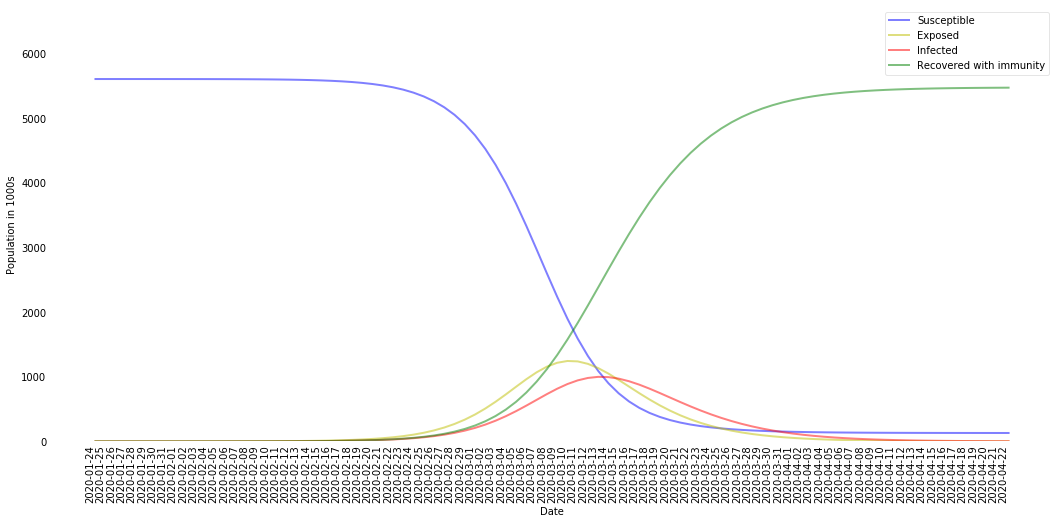

In [31]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot()
ax.plot(dates, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(dates, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(dates, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(dates, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

ax.set_xticks(range(n_days),2)
ax.set_xticklabels([str(d.date()) for d in datelist], rotation = 90, ha="right")
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('Date')
ax.set_ylabel(f'Population in {1000}s')
ax.set_ylim(0,N/1000+0.2*N/1000)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Infection numbers in table form

In [32]:
graph_values = pd.DataFrame(list(zip(dates, I)))
graph_values.iloc[:,1] = np.ceil(graph_values.iloc[:,1])
graph_values.columns = ['Date', 'Number of Infected People']
graph_values

,Date,Number of Infected People
0,2020-01-24,1.0
1,2020-01-25,12.0
2,2020-01-26,21.0
3,2020-01-27,31.0
4,2020-01-28,43.0
5,2020-01-29,58.0
6,2020-01-30,77.0
7,2020-01-31,102.0
8,2020-02-01,134.0
9,2020-02-02,176.0


# Conclusion

### Peak of infection

In [33]:
max_idx = graph_values['Number of Infected People'].argmax()
graph_values.iloc[max_idx,:]

Date                         2020-03-13
Number of Infected People        997767
Name: 49, dtype: object

By 13 March, if the spread of virus is not controlled, the model suggests a total of almost **1 million** patients infected with Wuhan virus in SG.

Limitations:
The SEIR model excludes possible imported infections from flights that were in operation before the lockdown of Wuhan Tianhe airport and the official cancellation of airline TR121 by Scoot on 23 Jan 2020. Hence, the initial infected population, I0, could be underestimated.

The model also misses out on possible imported infections from flights that are not in the list of domestic airport locations (as shown earlier) with flights from Wuhan aiport. No official ceasation of flights from affected cities has been announced by the airlines companies running them till date yet.

The deterministic SEIR model assumes a constant rate of spread, beta, of the virus which can take on different values when depending on the density of population.